In [1]:
#!pip install tensorflow[and-cuda]
#!python.exe -m pip install --upgrade pip
#!pip install -q tensorflow_data_validation
#!pip install apache-beam 
#!pip install graphviz
#!pip install ucimlrepo

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
from ucimlrepo import fetch_ucirepo 
import datetime, os
import tensorflow_data_validation as tfdv
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import confusion_matrix

In [3]:
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 

df = X.join(y)
df_t = df

In [4]:
df.shape

(178, 14)

We have 178 rows and 14 columns. There are 13 features and 1 target. These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. 

## EDA
Now we shall look at the data to find if there are any missing, null or NaN values. We'll also check the data types of the columns and check if there are any outliers and replace those value with the mean. 

### Below we'll check if there any null or nan values


In [5]:
df.isnull().values.any() 

False

We can also find more details of the dataframe using the .info method of pandas. Which shows that all the columns have no null or nan values as we found earlier and it also shows that all values are either int or float.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
 13  class

#### We can use to_numeric method to convert each value into numeric format and check for errors to find if there are any non numeric values in the data frame. The result is consistent with our findings from above.

In [7]:
df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

Alcohol                         True
Malicacid                       True
Ash                             True
Alcalinity_of_ash               True
Magnesium                       True
Total_phenols                   True
Flavanoids                      True
Nonflavanoid_phenols            True
Proanthocyanins                 True
Color_intensity                 True
Hue                             True
0D280_0D315_of_diluted_wines    True
Proline                         True
class                           True
dtype: bool

### Removing any duplicate rows

In [8]:
df.drop_duplicates(keep='first', inplace=True)

In [9]:
len(df)

178

There are no duplicate rows!

## Let's see how the data is distrbuted


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

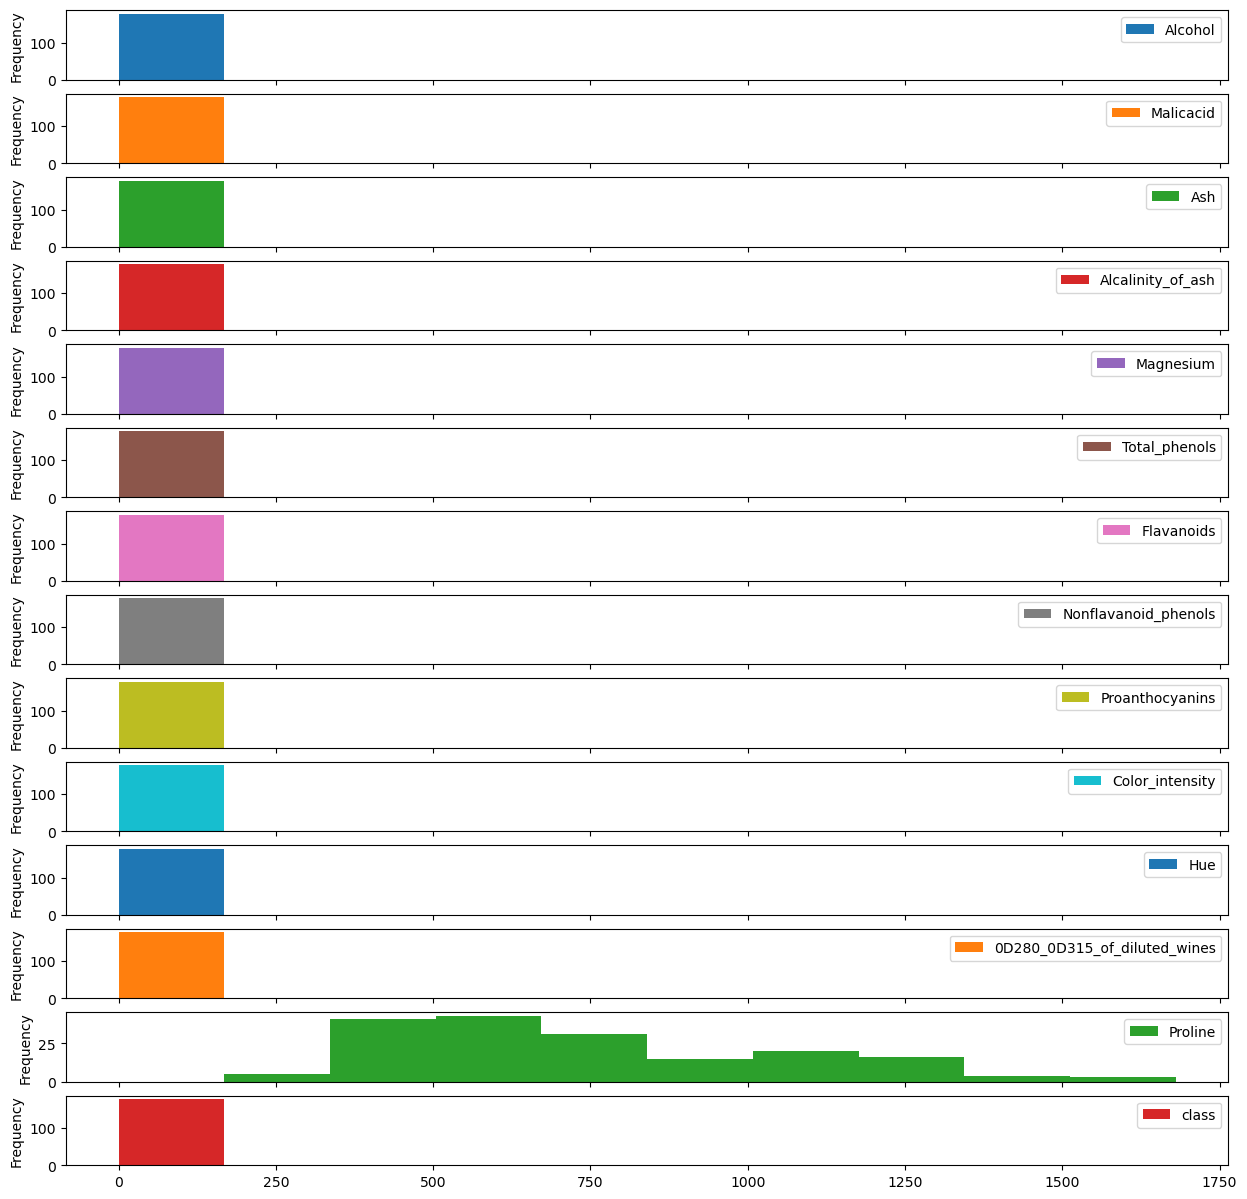

In [10]:
df.plot(kind='hist', legend=True, subplots=True, figsize =(15,15))

<AxesSubplot:>

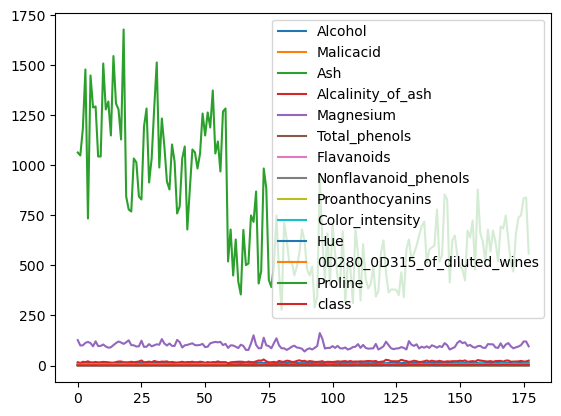

In [11]:
df.plot()

### Let's check the skewness. 
Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean


In [12]:
df.skew(axis = 0).sort_values()

0D280_0D315_of_diluted_wines   -0.307285
Ash                            -0.176699
Alcohol                        -0.051482
Hue                             0.021091
Flavanoids                      0.025344
Total_phenols                   0.086639
class                           0.107431
Alcalinity_of_ash               0.213047
Nonflavanoid_phenols            0.450151
Proanthocyanins                 0.517137
Proline                         0.767822
Color_intensity                 0.868585
Malicacid                       1.039651
Magnesium                       1.098191
dtype: float64

## From the above distribution it is clear that the dataset is not normally distribued but skewed towards the left.

<AxesSubplot:ylabel='Density'>

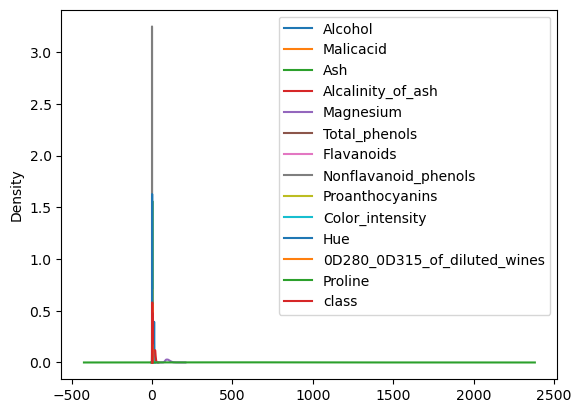

In [13]:
df.plot(kind = 'density')

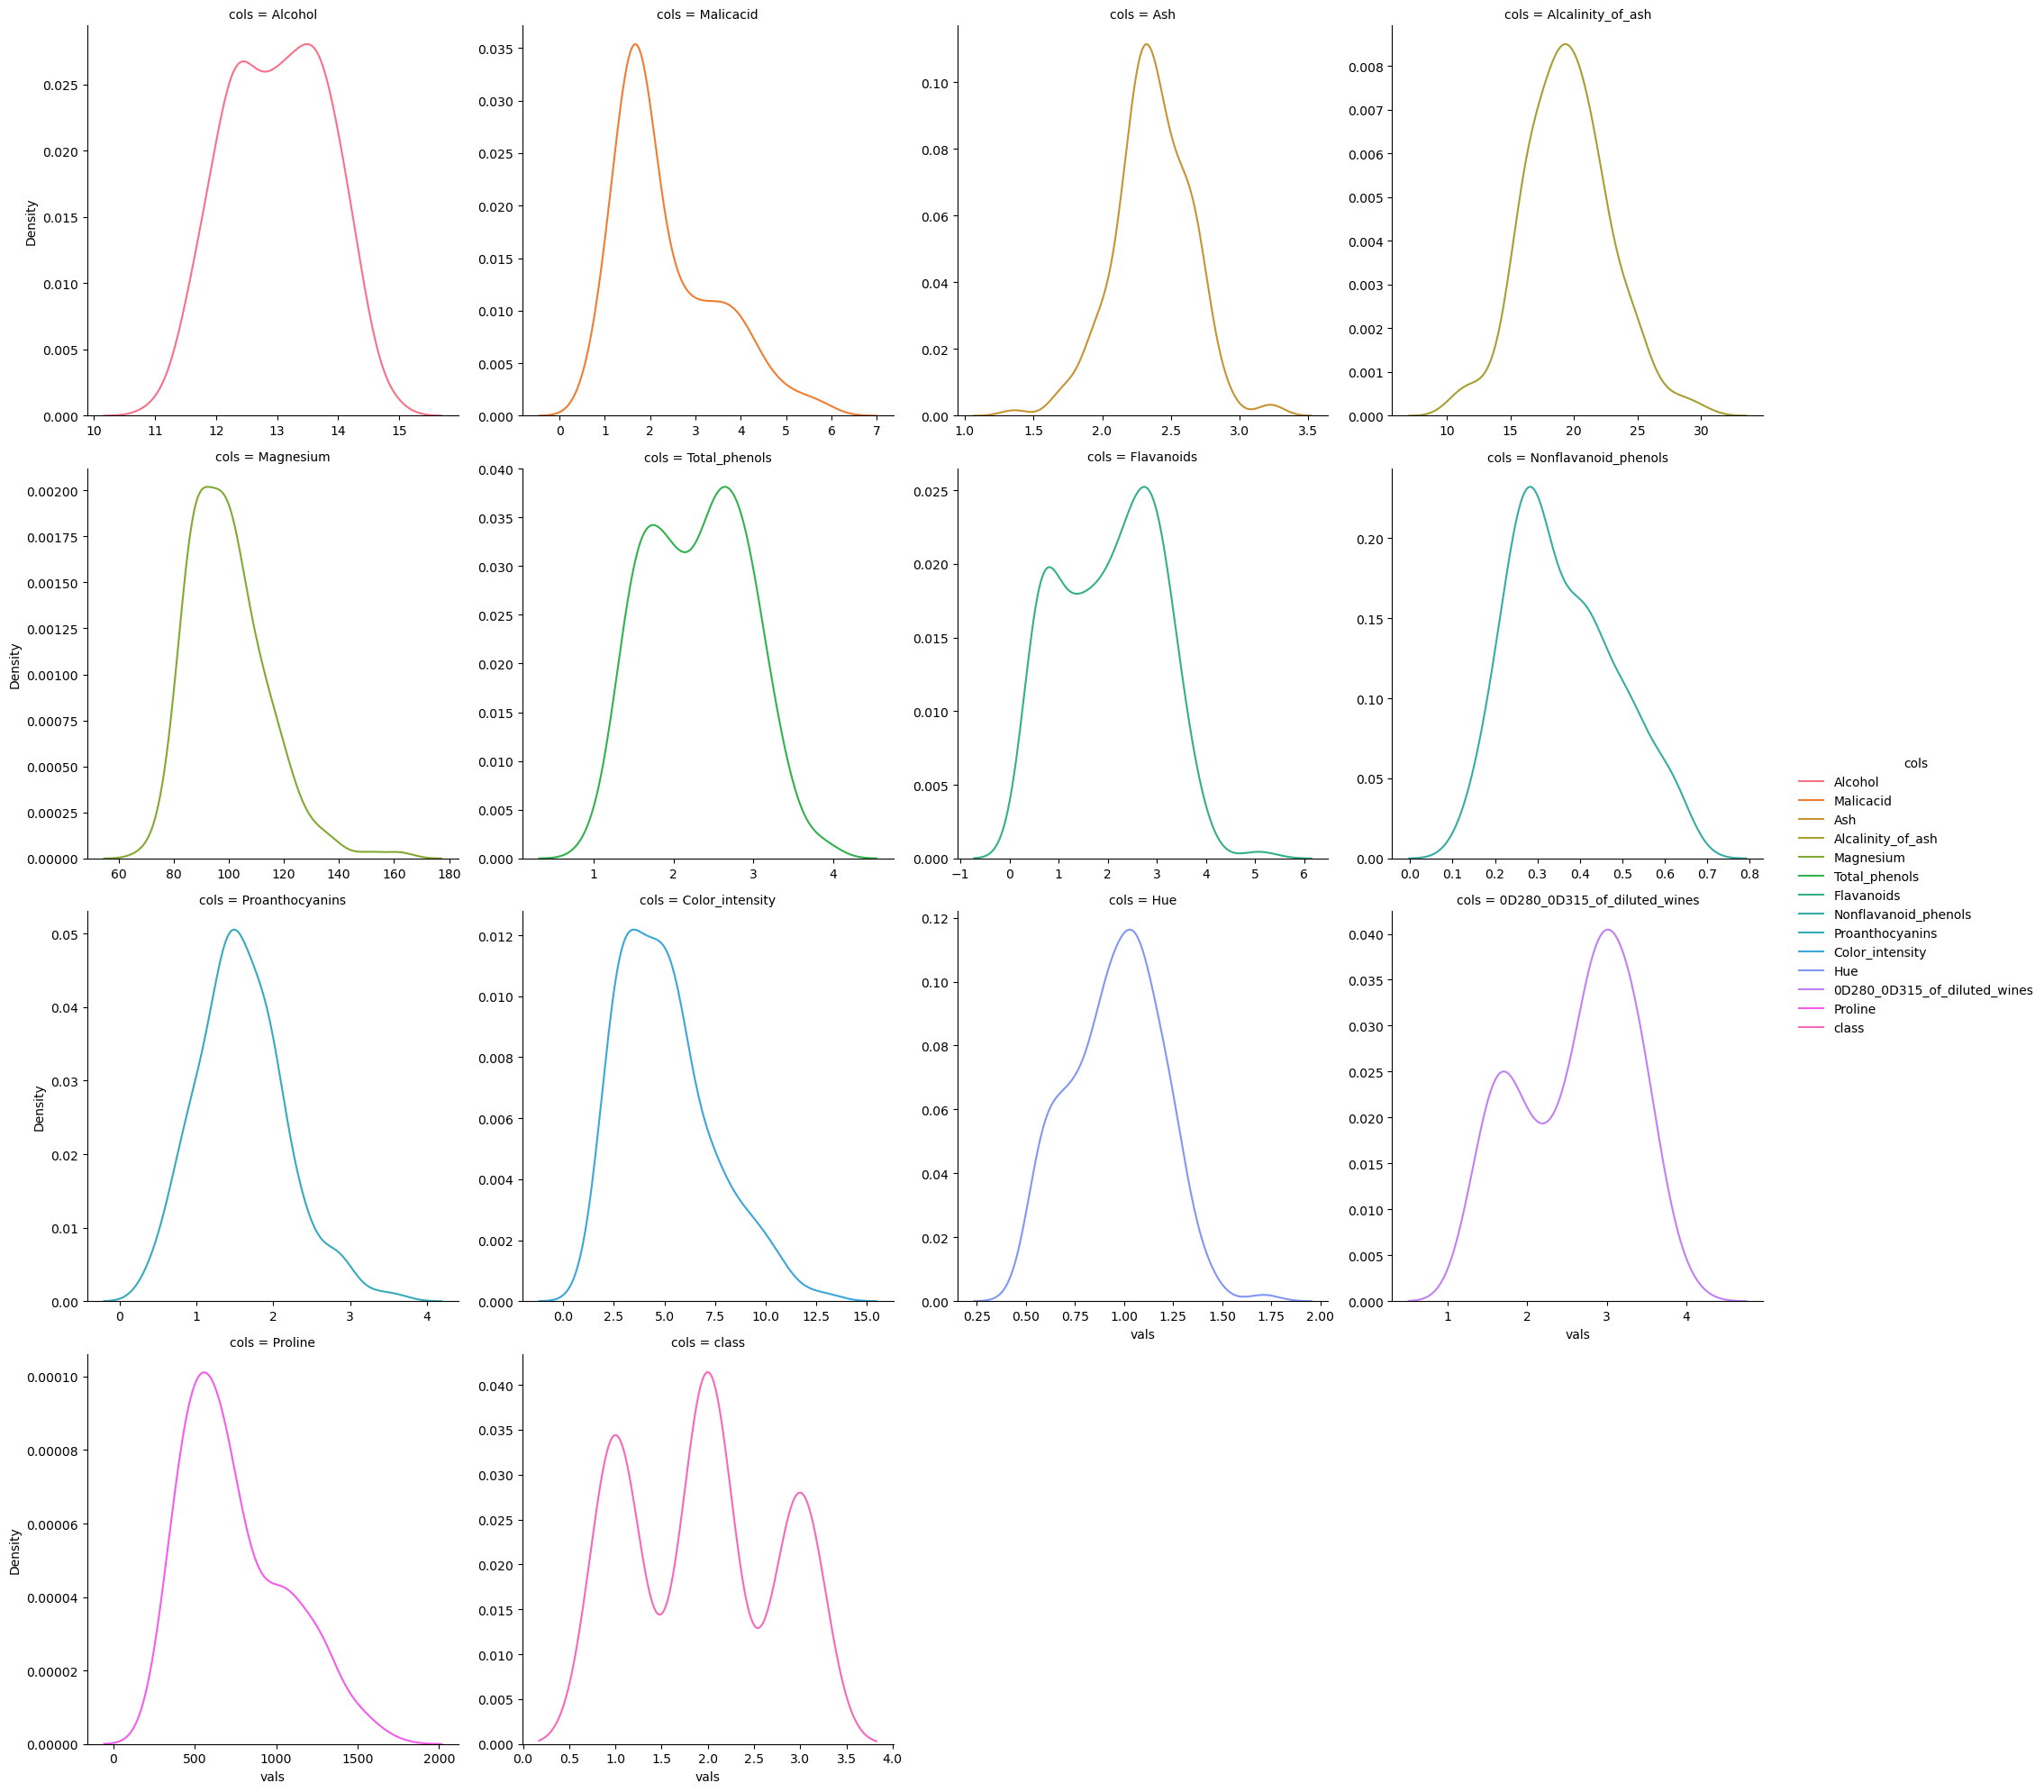

In [14]:
df1 = df.melt(var_name='cols',  value_name='vals')

sns.displot(kind='kde', data=df1, col='cols', col_wrap=4, x='vals', hue="cols", facet_kws={'sharey': False, 'sharex': False})

Most features are normally distributed where as some are left skewed. Class is multimodal as it has three classes. Overall the distribution shows normal like distribution and hence the learning should be quick

## Let's  deep dive into the dataset to see some metrics to understand how the data is distributed

In [15]:
df.describe()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,1.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,1.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,1.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,2.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,3.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,3.000000


From the values of min, max, standard deviation and quartiles it looks like we have some outliers in the dataset. To show visualise this in a better way we have plotted the box plots below

<AxesSubplot:>

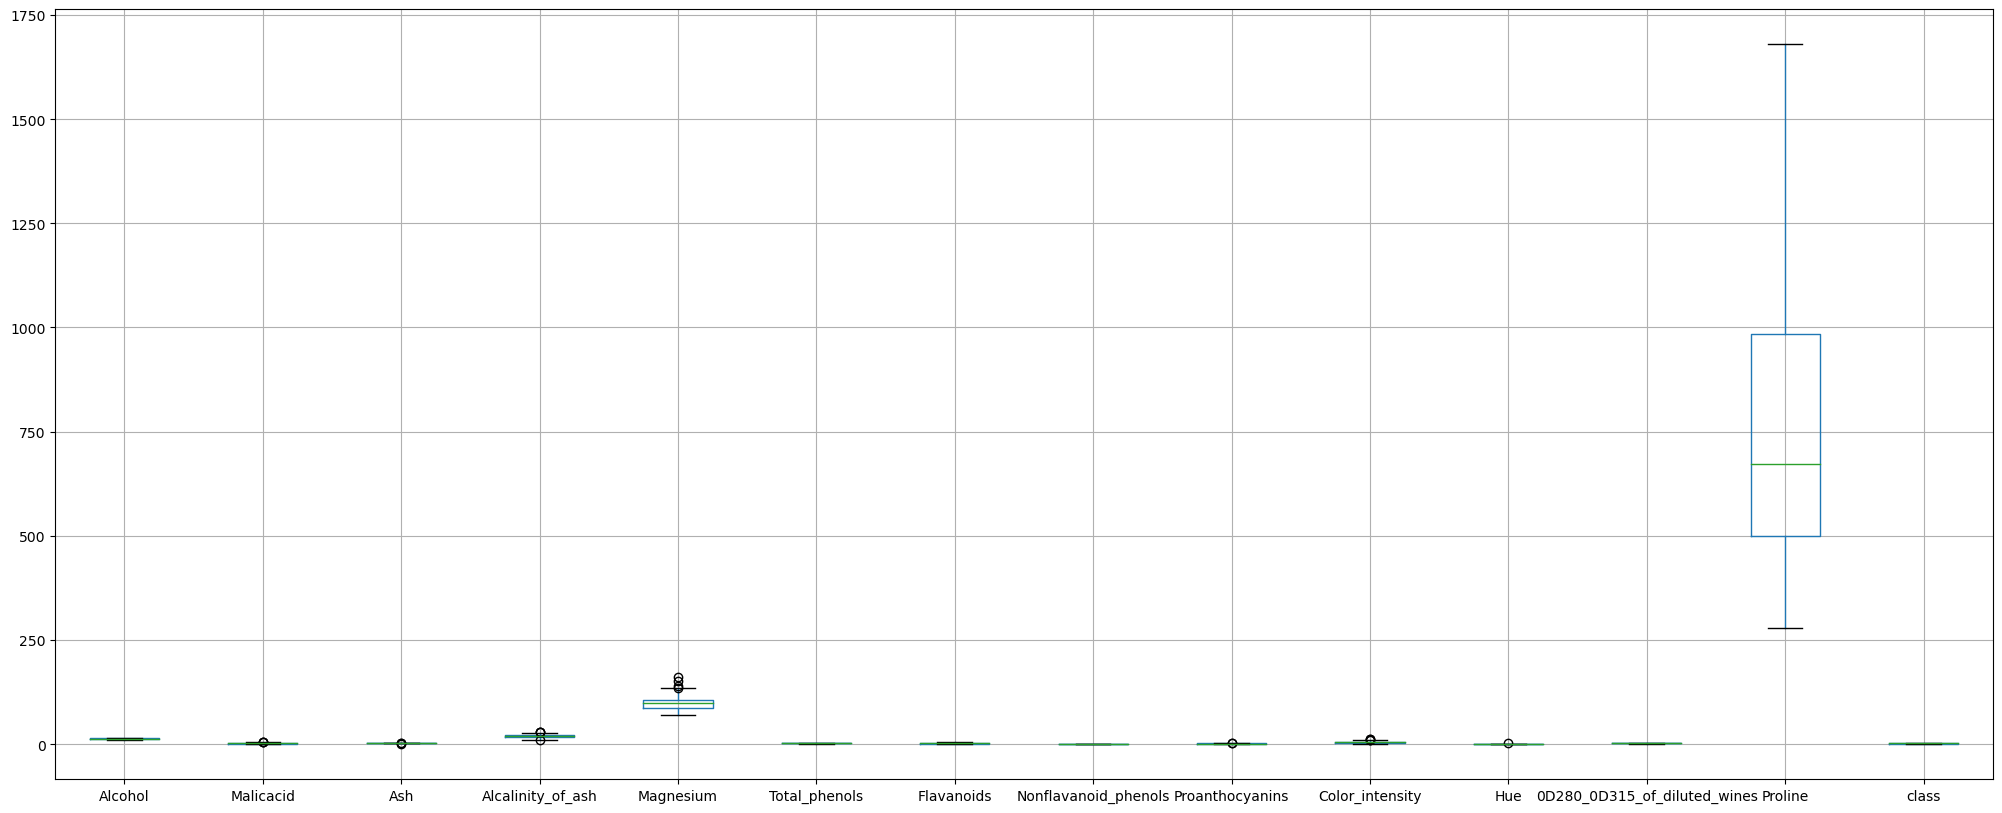

In [16]:
df.boxplot(figsize=(25,10))

#### Let's remove these outliers.

In [17]:
def remove_outlier(x):
    mean = df[x].quantile(0.50)
    Q1 = np.percentile(df[x], 25, method = 'midpoint')
    Q3 = np.percentile(df[x], 75, method = 'midpoint')
    IQR = Q3 - Q1
    upper= Q3 + 1.5*IQR
    lower= Q1 - 1.5*IQR

    #Here we are using the upperbound and lowerbounds and replacing the same with the mean of the respective feature.
    df[x] = np.where(df[x] > upper, mean, df[x])
    df[x] = np.where(df[x] < lower, mean, df[x])

for i in ['Alcohol','Malicacid','Ash','Alcalinity_of_ash','Magnesium',
          'Total_phenols','Flavanoids','Nonflavanoid_phenols','Proanthocyanins',
          'Color_intensity','Hue','0D280_0D315_of_diluted_wines','Proline']:
    remove_outlier(i)

<AxesSubplot:>

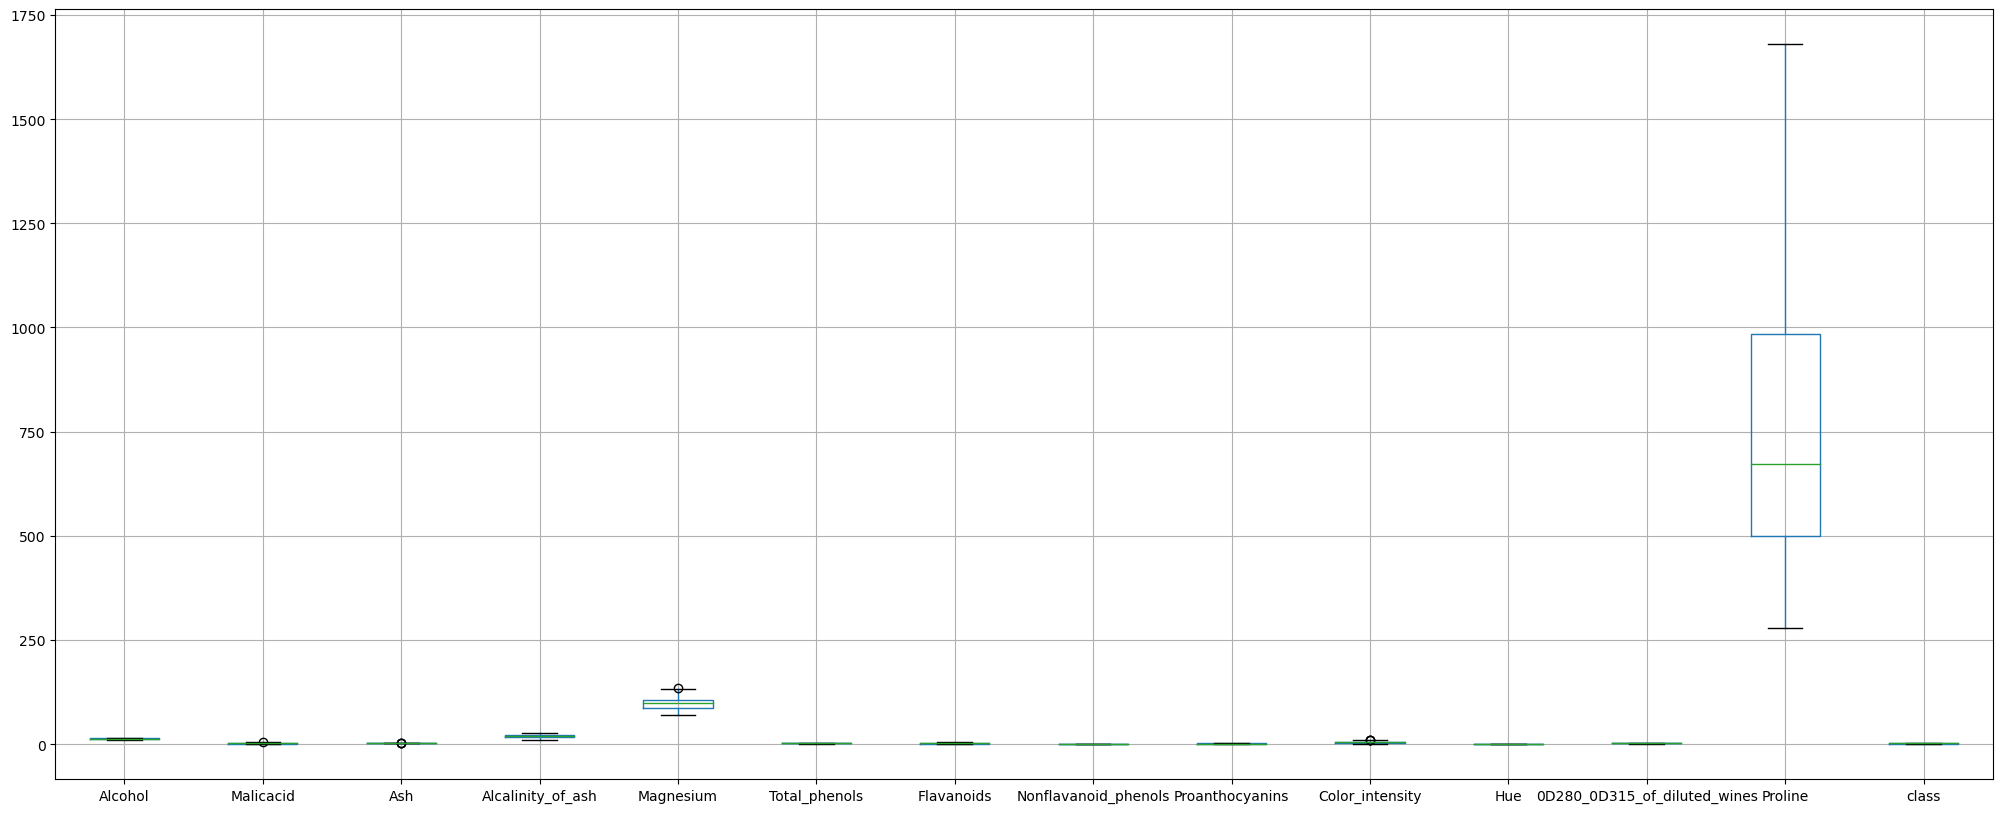

In [18]:
df.boxplot(figsize=(25,10))

### Using Tensorflow Data Validation 

In [19]:
stats = tfdv.generate_statistics_from_dataframe(df_t)
tfdv.visualize_statistics(stats)

In [20]:
schema = tfdv.infer_schema(stats)

In [21]:
anomalies = tfdv.validate_statistics(statistics=stats, schema=schema)

#### Check for anomalies

In [22]:
tfdv.display_anomalies(anomalies)

#### Dataset schema summary

In [23]:
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Alcohol',FLOAT,required,,-
'Malicacid',FLOAT,required,,-
'Ash',FLOAT,required,,-
'Alcalinity_of_ash',FLOAT,required,,-
'Magnesium',FLOAT,required,,-
'Total_phenols',FLOAT,required,,-
'Flavanoids',FLOAT,required,,-
'Nonflavanoid_phenols',FLOAT,required,,-
'Proanthocyanins',FLOAT,required,,-


In [24]:
serving_anomalies = tfdv.validate_statistics(stats, schema)

In [25]:
tfdv.display_anomalies(serving_anomalies)

# Scatter plot for the dataset 

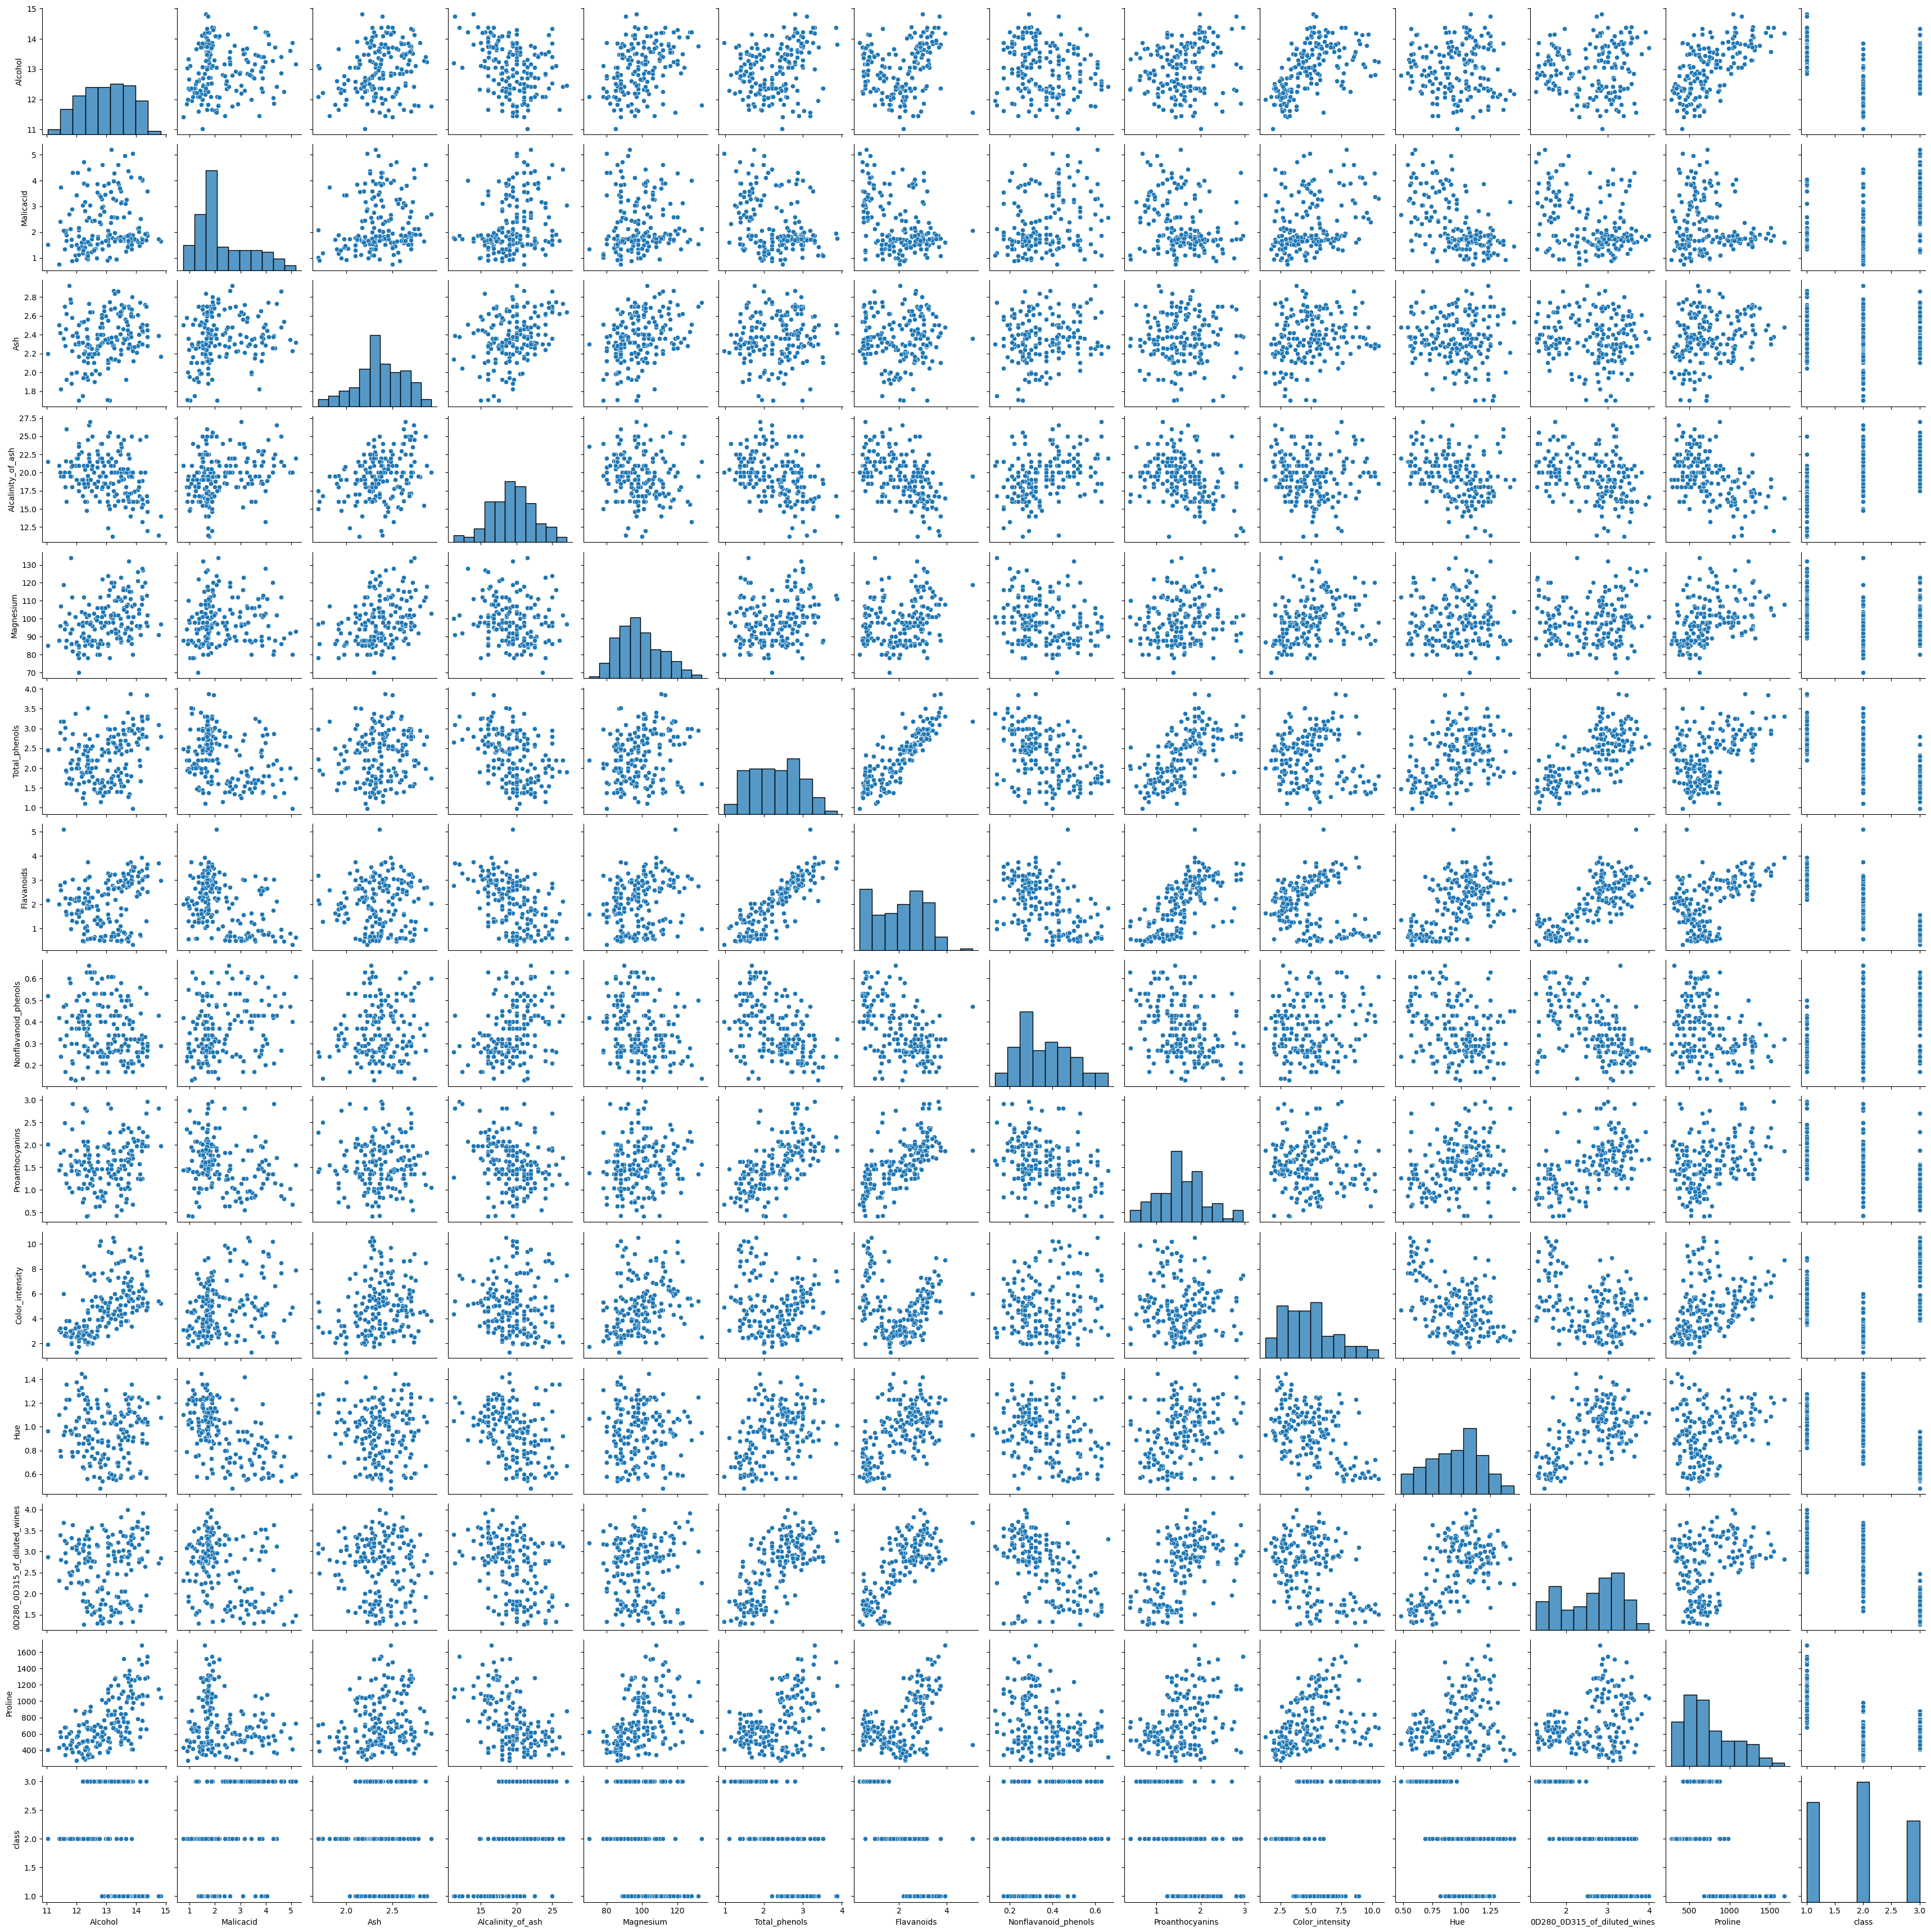

In [26]:
sns.pairplot(df)

The correlation is calculated is using pearson method and the values are between -1 and 1. As the values go towards they show higher positive correlation and as they go towards -1 they show negative correlation. We should remove features with high correlation for better slice of data for training our models. As mentioned above most features show evenly dense clusters and hence they form normal distributions.

## Let's standardise the data using standard scaler before training 


In [27]:
# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104,  test_size=0.2,  shuffle=True) 

In [28]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [29]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
df_train_scaled = pd.DataFrame(X_train)
df_train_scaled['class'] = y_train
df_train_scaled.columns = df.columns

In [31]:
df_train_scaled

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
0,-0.129254,-0.680019,0.498724,-0.525611,-0.302085,0.328325,0.390471,-0.868177,-0.181967,-0.442970,0.639146,1.488574,0.929265,1.0
1,-0.768081,-1.210296,-1.487828,-1.436926,2.778014,-0.621810,-0.135763,-0.132902,2.112502,-0.671860,0.499760,-0.441280,0.045000,NaN
2,-0.288961,-0.549623,-0.337719,0.902117,-1.128452,-1.473655,-0.226842,0.929162,0.118079,-0.715047,-0.336555,-0.280459,-0.829254,1.0
3,1.750374,1.049903,-0.337719,-1.072400,0.223786,1.589711,1.200062,-0.786479,1.106466,-0.024057,0.406837,1.210792,1.096108,1.0
4,0.828988,-0.497464,1.126056,-0.707874,0.975030,0.934446,0.936945,-0.541388,-0.181967,1.012428,1.521923,0.392066,1.913636,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2.303206,-0.645246,-0.721088,-1.679944,-0.151836,0.852537,1.007784,-0.623085,0.735821,0.105504,0.592684,0.348206,1.029371,3.0
138,-1.431479,-0.219286,1.404871,2.724748,-0.527458,-0.245032,0.258912,1.746134,0.347526,-0.844608,0.081603,-0.251219,-0.902665,3.0
139,0.607855,1.145527,0.777539,1.054003,0.899905,-0.949443,-1.076913,0.520676,-0.181967,2.472145,-0.475941,-1.537788,-0.138526,3.0
140,0.693851,0.684794,1.195760,1.205889,-0.151836,-1.195167,-1.481708,1.092556,-1.788094,-0.261585,-0.290093,-0.806783,-0.722475,3.0


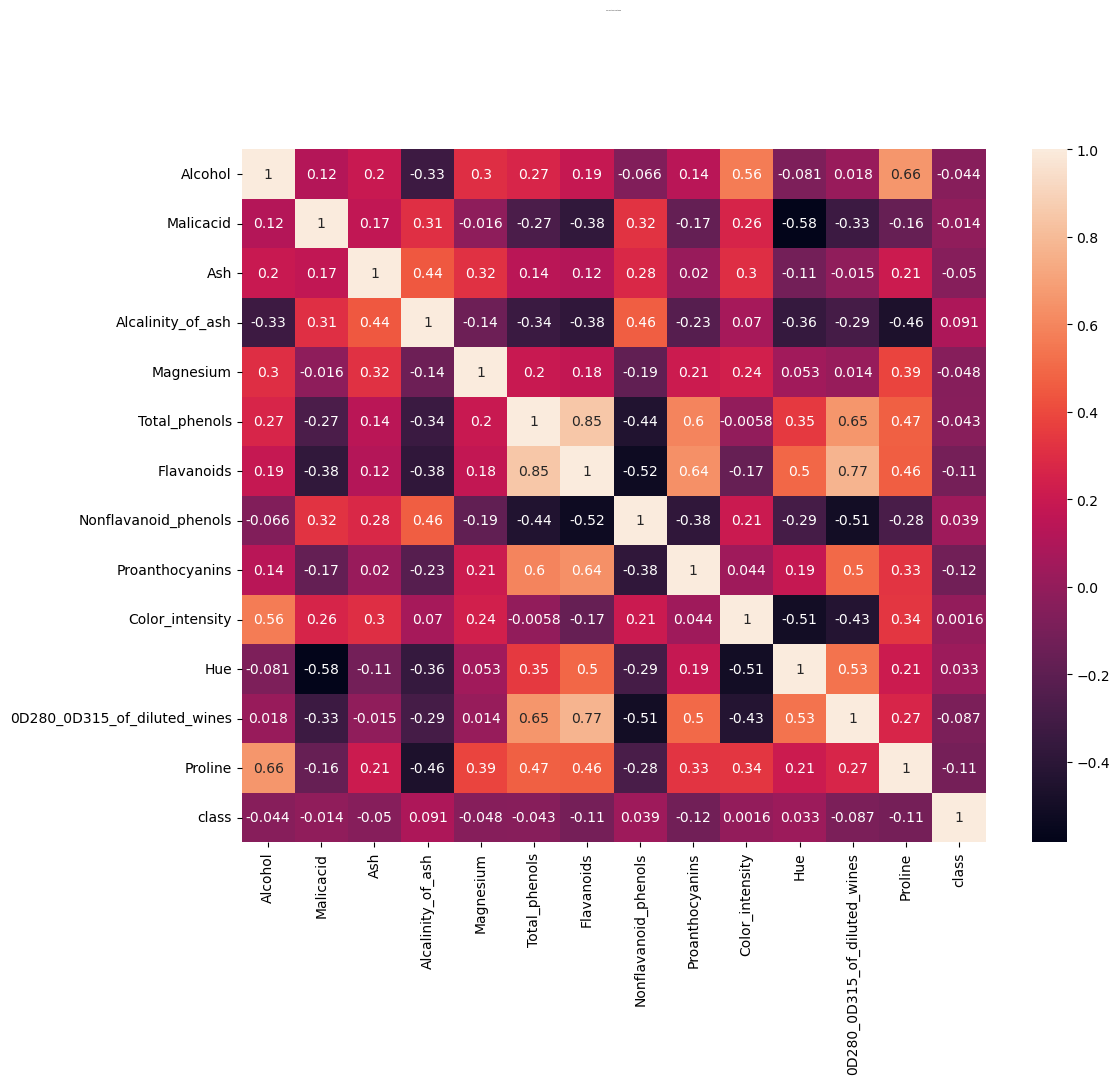

In [32]:
plt.figure(figsize=(12, 9))
sns.heatmap(df_train_scaled.corr(),annot=True).set_title('Correlation Heatmap', fontdict={'fontsize':1}, pad=100);

### Correlation score of each feature in order 

In [33]:
corr_matrix = df_train_scaled.corr()
print(corr_matrix["class"].sort_values(ascending=False))

class                           1.000000
Alcalinity_of_ash               0.090549
Nonflavanoid_phenols            0.039463
Hue                             0.032553
Color_intensity                 0.001592
Malicacid                      -0.014479
Total_phenols                  -0.043242
Alcohol                        -0.044263
Magnesium                      -0.048080
Ash                            -0.049908
0D280_0D315_of_diluted_wines   -0.086543
Proline                        -0.108251
Flavanoids                     -0.109089
Proanthocyanins                -0.124645
Name: class, dtype: float64


# Feature Importance

### Now let's use f_regression for feature selection. The F-value and p-value computed by f_regression() can be used to determine which features are most relevant to predicting the target variable. In general, you want to keep the features with the highest F-values and lowest p-values, as these features have the strongest linear relationship with the target variable

In [34]:
# Applying SelectKBest class to extract top 15 best features
fs = SelectKBest(score_func=f_regression,k=10)
# Applying feature selection
fit = fs.fit(X,y)
features_score = pd.DataFrame(fit.scores_)
features = pd.DataFrame(X.columns)
feature_score = pd.concat([features,features_score],axis=1)
# Assigning column names
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(15,columns="F_Score"))

                  Input_Features     F_Score
6                     Flavanoids  448.671871
11  0D280_0D315_of_diluted_wines  288.755043
5                  Total_phenols  188.537094
12                       Proline  118.116155
10                           Hue  108.396065
3              Alcalinity_of_ash   64.495659
8                Proanthocyanins   58.394950
7           Nonflavanoid_phenols   55.343880
1                      Malicacid   41.726932
0                        Alcohol   21.249632
9                Color_intensity   13.365259
4                      Magnesium    8.053446
2                            Ash    0.434815


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
feature_score.nlargest(15,columns="F_Score")['Input_Features'].head(8).values

array(['Flavanoids', '0D280_0D315_of_diluted_wines', 'Total_phenols',
       'Proline', 'Hue', 'Alcalinity_of_ash', 'Proanthocyanins',
       'Nonflavanoid_phenols'], dtype=object)

In [36]:
X_train_fs = df_train_scaled[['Flavanoids', '0D280_0D315_of_diluted_wines', 'Total_phenols',
       'Proline', 'Hue', 'Alcalinity_of_ash', 'Proanthocyanins',
       'Nonflavanoid_phenols']]

In [37]:
df_test_scaled = pd.DataFrame(X_test)
df_test_scaled['class'] = y_test
df_test_scaled.columns = df.columns

In [38]:
X_test_fs = df_test_scaled[['Flavanoids', '0D280_0D315_of_diluted_wines', 'Total_phenols',
       'Proline', 'Hue', 'Alcalinity_of_ash', 'Proanthocyanins',
       'Nonflavanoid_phenols']]

# Building the model for classification

In [66]:
tf.keras.backend.clear_session()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [67]:
X_train_fs.shape

(142, 8)

### Using two models with relu and sigmoid activations. By design Relu shows steep and linear learning growth whereas Sigmoid shows sinusoidal growth. The model2 with Relu should learn quickly compared to model1 with sigmoid.  

In [68]:
#Configure the model
learning_rate = tf.Variable(0.001, trainable=False)

tf.keras.backend.set_value(learning_rate, 0.001)

model1 = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(8, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(6, activation=tf.nn.sigmoid),  
                                    tf.keras.layers.Dense(5, activation=tf.nn.sigmoid), 
                                    tf.keras.layers.Dense(4, activation=tf.nn.softmax)])

model2 = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(8, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(6, activation=tf.nn.relu),  
                                    tf.keras.layers.Dense(5, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(4, activation=tf.nn.softmax)])

In [69]:
model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model1.fit(X_train_fs.values, y_train.values, epochs=229,callbacks=[tensorboard_callback])


Epoch 1/229
5/5 [==============================] - 1s 30ms/step - loss: 1.4254 - accuracy: 0.2676
Epoch 2/229
5/5 [==============================] - 0s 16ms/step - loss: 1.4133 - accuracy: 0.2676
Epoch 3/229
5/5 [==============================] - 0s 16ms/step - loss: 1.4019 - accuracy: 0.2676
Epoch 4/229
5/5 [==============================] - 0s 15ms/step - loss: 1.3909 - accuracy: 0.2676
Epoch 5/229
5/5 [==============================] - 0s 18ms/step - loss: 1.3809 - accuracy: 0.2676
Epoch 6/229
5/5 [==============================] - 0s 15ms/step - loss: 1.3715 - accuracy: 0.2746
Epoch 7/229
5/5 [==============================] - 0s 16ms/step - loss: 1.3617 - accuracy: 0.2887
Epoch 8/229
5/5 [==============================] - 0s 15ms/step - loss: 1.3528 - accuracy: 0.3239
Epoch 9/229
5/5 [==============================] - 0s 15ms/step - loss: 1.3443 - accuracy: 0.3169
Epoch 10/229
5/5 [==============================] - 0s 15ms/step - loss: 1.3355 - accuracy: 0.3592
Epoch 11/229
5/5 [=

5/5 [==============================] - 0s 16ms/step - loss: 0.6287 - accuracy: 0.6972
Epoch 166/229
5/5 [==============================] - 0s 15ms/step - loss: 0.6261 - accuracy: 0.6972
Epoch 167/229
5/5 [==============================] - 0s 15ms/step - loss: 0.6237 - accuracy: 0.6972
Epoch 168/229
5/5 [==============================] - 0s 15ms/step - loss: 0.6210 - accuracy: 0.6972
Epoch 169/229
5/5 [==============================] - 0s 15ms/step - loss: 0.6185 - accuracy: 0.6972
Epoch 170/229
5/5 [==============================] - 0s 16ms/step - loss: 0.6162 - accuracy: 0.6972
Epoch 171/229
5/5 [==============================] - 0s 15ms/step - loss: 0.6138 - accuracy: 0.6972
Epoch 172/229
5/5 [==============================] - 0s 15ms/step - loss: 0.6114 - accuracy: 0.6972
Epoch 173/229
5/5 [==============================] - 0s 17ms/step - loss: 0.6092 - accuracy: 0.7042
Epoch 174/229
5/5 [==============================] - 0s 16ms/step - loss: 0.6069 - accuracy: 0.7042
Epoch 175/229


In [70]:
model2.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.fit(X_train_fs.values, y_train.values, epochs=100,callbacks=[tensorboard_callback])


Epoch 1/100
5/5 [==============================] - 1s 23ms/step - loss: 1.3839 - accuracy: 0.2817
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3674 - accuracy: 0.2958
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3537 - accuracy: 0.2958
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 1.3403 - accuracy: 0.2958
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 1.3282 - accuracy: 0.3099
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 1.3163 - accuracy: 0.3099
Epoch 7/100
5/5 [==============================] - 0s 16ms/step - loss: 1.3047 - accuracy: 0.3169
Epoch 8/100
5/5 [==============================] - 0s 15ms/step - loss: 1.2922 - accuracy: 0.3169
Epoch 9/100
5/5 [==============================] - 0s 15ms/step - loss: 1.2803 - accuracy: 0.3169
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.2679 - accuracy: 0.3169
Epoch 11/100
5/5 [=

Both models show similar accuracy on training but model 1 takes more epochs to learn from the training data.

### Loss Vs Accuracy for both models

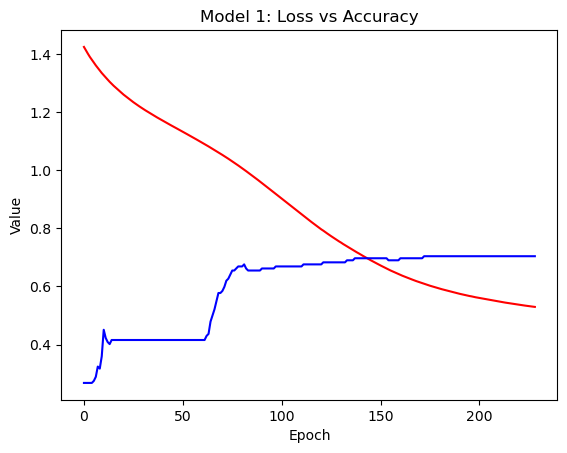

In [75]:
# Get the loss and accuracy values
loss = model1.history.history['loss']
accuracy = model1.history.history['accuracy']

# Plot the loss and accuracy values
plt.plot(loss, c ='red')
plt.plot(accuracy, c='blue')
plt.title('Model 1: Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

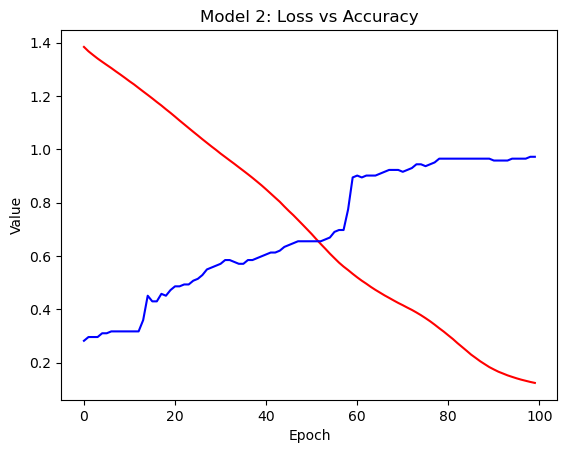

In [82]:
# Get the loss and accuracy values
loss = model2.history.history['loss']
accuracy = model2.history.history['accuracy']

# Plot the loss and accuracy values
plt.plot(loss, c ='red')
plt.plot(accuracy, c='blue')
plt.title('Model 2: Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.show()

Growth of model2 is higher and quicker 

## Tensorboard visualisation

In [44]:
%load_ext tensorboard

In [46]:
%tensorboard --logdir logs

In [47]:
y_pred = model2.predict(X_test_fs)

2/2 [==============================] - 0s 3ms/step


# Converting the predictions to numeric labels

In [48]:
prediction = np.array(y_pred)
y_p = np.argmax(prediction, axis = 1)

In [49]:
cm = confusion_matrix(y_test, y_p)

In [50]:
cm_df = pd.DataFrame(cm,
                     index = ['1','2','3'], 
                     columns = ['1','2','3'])

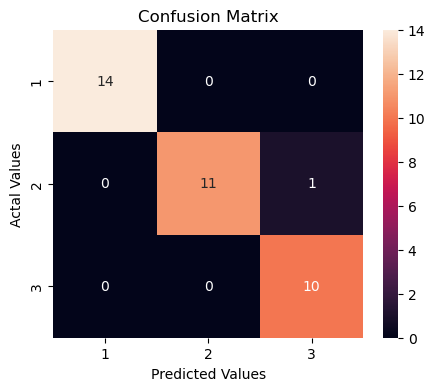

In [84]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Future Scope
1. Feature engineering 
2. One hot encoding for the target labels
3. Kfold cross validation
4. Better Boxplot for outlier visualisation